In [112]:
import matplotlib.pyplot as plt
from random import uniform, seed
from math import sqrt
import numpy as np
import quantecon as qe

In [2]:
# defining the agent class
class Agent:
    def __init__(self,type):
        self.type = type
        self.draw_location()

    def draw_location(self):
        self.location = uniform(0,1), uniform(0,1)

    def get_distance(self,other):
        a = (self.location[0]-other.location[0])**2
        b = (self.location[1]-other.location[1])**2
        return sqrt(a+b)
    
    # agent is "happy" if at least 5/10 neighbors are of the same type
    def happy(self, agents, num_neighbors = 10, require_same_type = 5):
        distances = [] # list of (distance,agent)
        for agent in agents:
            if self != agent:
                distance = self.get_distance(agent)
                distances.append((distance,agent))

        # gets the 10 closest agents as neighbors to the current agent
        distances.sort()
        neighbors = [agent for d, agent in distances[:num_neighbors]]
        num_same_type = sum(self.type == agent.type for agent in neighbors)
        return num_same_type >= require_same_type
    
    def update(self, agents):
        while not self.happy(agents):
            self.draw_location()

In [3]:
def plot_distribution(agents, cycle_num):
    "Plot the distribution of agents after cycle_num rounds of the loop."
    x_values_0, y_values_0 = [], []
    x_values_1, y_values_1 = [], []
    # == Obtain locations of each type == #
    for agent in agents:
        x, y = agent.location
        if agent.type == 0:
            x_values_0.append(x)
            y_values_0.append(y)
        else:
            x_values_1.append(x)
            y_values_1.append(y)
    fig, ax = plt.subplots()
    plot_args = {'markersize': 8, 'alpha': 0.8}
    ax.set_facecolor('azure')
    ax.plot(x_values_0, y_values_0,
        'o', markerfacecolor='orange', **plot_args)
    ax.plot(x_values_1, y_values_1,
        'o', markerfacecolor='green', **plot_args)
    ax.set_title(f'Cycle {cycle_num-1}')
    plt.show()

In [4]:
def run_simulation(num_of_type_0 = 600,
                   num_of_type_1 = 600,
                   max_iter = 100_000,
                   set_seed = 1234):
    
    seed(set_seed) # for reproducibility

    # create a list of agents of type 0 then extend to incl type 1
    agents = [Agent(0) for i in range(num_of_type_0)]
    agents.extend(Agent(1) for i in range(num_of_type_1))

    count = 1
    plot_distribution(agents,count)

    while count < max_iter:
        print("Entering loop", count)
        count += 1
        no_one_moved = True # flag to check when to stop the loop
        for agent in agents:
            old_location = agent.location
            agent.update(agents)
            if agent.location != old_location:
                no_one_moved = False
        if no_one_moved:
            break

        plot_distribution(agents,count) # final distribution

        if count < max_iter:
            print(f"Converged after {count} iterations.")
        else:
            print("Hit iteration bound and terminated")

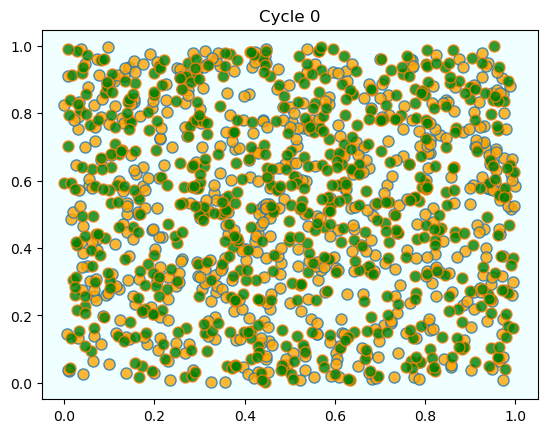

Entering loop 1


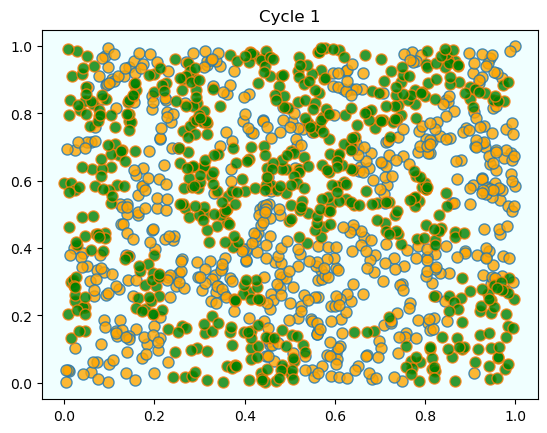

Converged after 2 iterations.
Entering loop 2


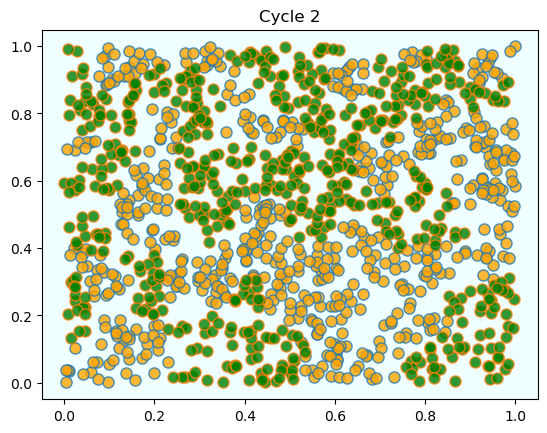

Converged after 3 iterations.
Entering loop 3


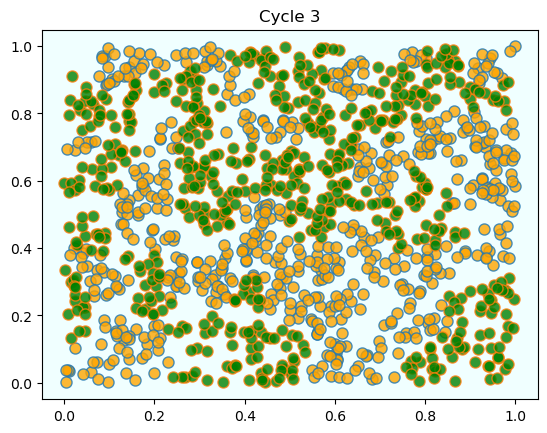

Converged after 4 iterations.
Entering loop 4


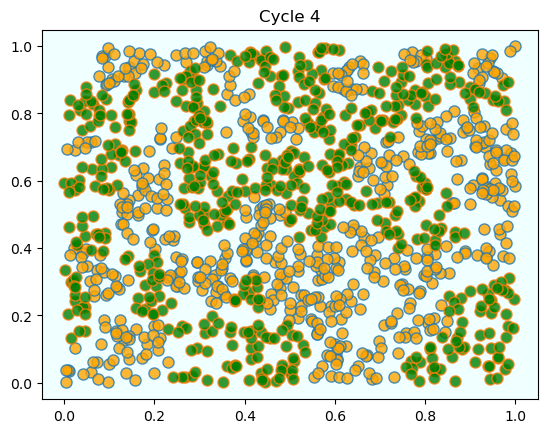

Converged after 5 iterations.
Entering loop 5


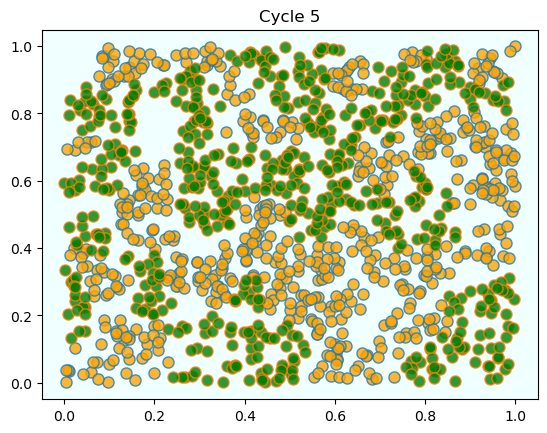

Converged after 6 iterations.
Entering loop 6


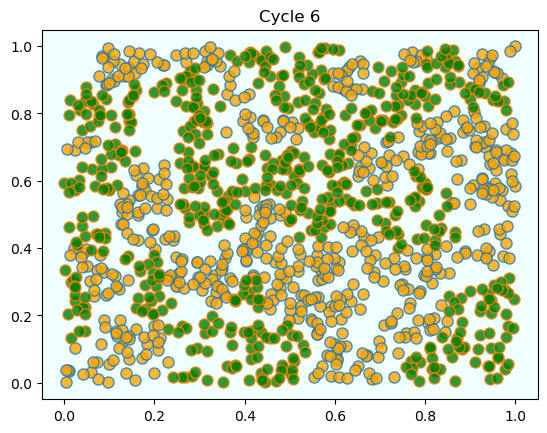

Converged after 7 iterations.
Entering loop 7


In [5]:
run_simulation()

# Exercise 23.1


The object oriented style that we used for coding above is neat but harder to optimize than procedural code (i.e., code based around functions rather than objects and methods).

Try writing a new version of the model that stores

    the locations of all agents as a 2D NumPy array of floats.

    the types of all agents as a flat NumPy array of integers.

Write functions that act on this data to update the model using the logic similar to that described above.

However, implement the following two changes:

    Agents are offered a move at random (i.e., selected randomly and given the opportunity to move).

    After an agent has moved, flip their type with probability 0.01

The second change introduces extra randomness into the model.

(We can imagine that, every so often, an agent moves to a different city and, with small probability, is replaced by an agent of the other type.)

In [114]:
# all the functions here
def create_agents(num_type_0,num_type_1):
    num_agents = num_type_0 + num_type_1
    a = np.random.uniform(size = num_agents)
    b = np.random.uniform(size = num_agents)
    locations = np.empty((num_agents,2)) # stores all locations in a 2D numpy array

    for location in range(num_agents):
        locations[location] = (a[location],b[location])

    agent_type_0 = np.full(num_type_0,0)
    agent_type_1 = np.full(num_type_1,1)
    agents = np.concatenate((agent_type_0,agent_type_1)) # lists all agent 0s then all agent 1s
    return agents, locations

# input the index number of both agents + the locations array
def get_distance(self_num,other_num,locations): 
    a = (locations[self_num][0] - locations[other_num][0])**2
    b = (locations[self_num][1] - locations[other_num][1])**2
    return sqrt(a+b)

def happy(self_num, agents, locations, num_neighbors = 10, require_same_type = 5):
    distances = []
    for agent in range(len(agents)):
        if agent != self_num:
            distance = get_distance(self_num,agent,locations)
            distances.append((distance,agent))
    # gets 10 nearest agents
    distances.sort()
    neighbors = [agent for d, agent in distances[:num_neighbors]] # gives the indices of cloests 10 neighbors

    self_type = agents[self_num]
    num_same_type = 0
    for neighbor in neighbors:
        if agents[neighbor] == self_type:
            num_same_type += 1

    return num_same_type >= require_same_type

def update(self_num, agents, locations, move_prob = 0.3, flip_prob = 0.01):
    # 30% chance of agent being offered a move
    agent_move = qe.random.draw([float(1-move_prob), 1.0]) # returns 1 => move
    # 1% chance of the agent type flipping
    agent_flip = qe.random.draw([float(1-flip_prob), 1.0]) # returns 1 => flip

    if agent_move == 1:
        if not happy(self_num, agents,locations):
            a = np.random.uniform()
            b = np.random.uniform()
            locations[self_num] = (a,b)
            if agent_flip == 1:
                agent_type = agents[self_num]
                if agent_type == 0:
                    agents[self_num] = 1
                else:
                    agents[self_num] = 0

def plot_sim(agents, locations, cycle_num):
    x_values_0, y_values_0 = [],[]
    x_values_1, y_values_1 = [],[]

    # get location of each type
    for agent in range(len(agents)):
        x,y = locations[agent]
        if agents[agent] == 0:
            x_values_0.append(x)
            y_values_0.append(y)
        else:
            x_values_1.append(x)
            y_values_1.append(y)
    
    fig, ax = plt.subplots()
    plot_args = {'markersize': 8, 'alpha': 0.8}
    ax.set_facecolor('azure')
    ax.plot(x_values_0, y_values_0,
        'o', markerfacecolor='orange', **plot_args)
    ax.plot(x_values_1, y_values_1,
        'o', markerfacecolor='green', **plot_args)
    ax.set_title(f'Cycle {cycle_num-1}')
    plt.show()

# main fn
def simulate(num_type_0, num_type_1, 
             move_prob = 0.3, flip_prob = 0.01, 
             max_iter = 100_000, set_seed = 1234):
    seed(set_seed)

    agents, locations = create_agents(num_type_0,num_type_1)
    counter = 1
    while counter < max_iter:
        print("Entering loop", counter)
        counter += 1
        no_one_moved = True # flag to check if we're done with the sim
        for agent in range(len(agents)):
            cur_locations = locations.copy() # to prevent updating locations messing up old locations
            old_location = cur_locations[agent]
            update(agent, agents, locations, move_prob=move_prob, flip_prob=flip_prob)
            if not np.array_equal(old_location, locations[agent]):
                no_one_moved = False
        if no_one_moved:
            break
    
    # plot final distribution
    plot_sim(agents,locations,counter)
    if counter < max_iter:
        print(f"Converged after {counter} iterations")
    else:
        print("Hit iteration bound and terminated")

Entering loop 1
Entering loop 2
Entering loop 3
Entering loop 4
Entering loop 5
Entering loop 6
Entering loop 7
Entering loop 8
Entering loop 9
Entering loop 10
Entering loop 11
Entering loop 12
Entering loop 13
Entering loop 14
Entering loop 15
Entering loop 16
Entering loop 17
Entering loop 18
Entering loop 19
Entering loop 20
Entering loop 21
Entering loop 22
Entering loop 23
Entering loop 24
Entering loop 25
Entering loop 26
Entering loop 27
Entering loop 28
Entering loop 29
Entering loop 30
Entering loop 31
Entering loop 32
Entering loop 33
Entering loop 34
Entering loop 35
Entering loop 36
Entering loop 37
Entering loop 38
Entering loop 39


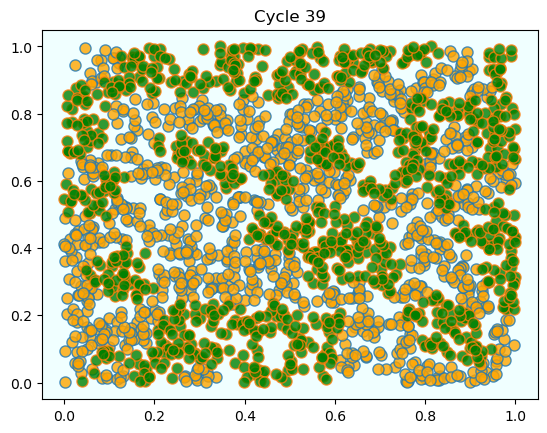

Converged after 40 iterations


In [115]:
simulate(1000,1000)